# 📊 Notebook 5: Confidence Intervals (CI)

**Project:** Telco Customer Churn Analysis  
**Goal:** Estimate population parameters (churn rate, average charges) with quantified uncertainty using Confidence Intervals.

---

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

df = pd.read_csv('../data/processed/telco_churn_cleaned.csv')

## 2. Confidence Interval for Churn Rate (Proportion)

We have a sample churn rate. What is the true population churn rate (with 95% confidence)?

Formula for Proportion CI:
$$ \hat{p} \pm Z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}} $$

In [2]:
from statsmodels.stats.proportion import proportion_confint

n_total = len(df)
n_churned = df['Churn_Numeric'].sum()

# Calculate 95% CI
ci_lower, ci_upper = proportion_confint(n_churned, n_total, alpha=0.05, method='normal')

print(f"Sample Churn Rate: {n_churned/n_total:.2%}")
print(f"95% Confidence Interval: [{ci_lower:.2%}, {ci_upper:.2%}]")

Sample Churn Rate: 26.54%
95% Confidence Interval: [25.51%, 27.57%]


**Business Impact:** We are 95% confident that the true churn rate is between **25.5% and 27.5%**. Any retention strategy must aim to reduce the rate below this lower bound to be considered statistically successful.

## 3. Confidence Interval for Average Revenue (Mean)

What is the average monthly revenue per customer?

Formula: $\bar{x} \pm Z \frac{s}{\sqrt{n}}$ (for large n)

In [3]:
mean_rev = df['MonthlyCharges'].mean()
std_rev = df['MonthlyCharges'].std()
n = len(df)

# Calculate standard error
se = std_rev / np.sqrt(n)

# 95% CI (Z=1.96)
ci_rev_lower, ci_rev_upper = stats.norm.interval(0.95, loc=mean_rev, scale=se)

print(f"Average Monthly Revenue: ${mean_rev:.2f}")
print(f"95% Confidence Interval: [${ci_rev_lower:.2f}, ${ci_rev_upper:.2f}]")

Average Monthly Revenue: $64.76
95% Confidence Interval: [$64.06, $65.46]


## 4. Comparing CIs: Fiber vs DSL Revenue

Do the confidence intervals for Fiber and DSL revenue overlap?

Fiber Revenue CI: [$91.05, $91.95]
DSL Revenue CI:   [$57.45, $58.75]


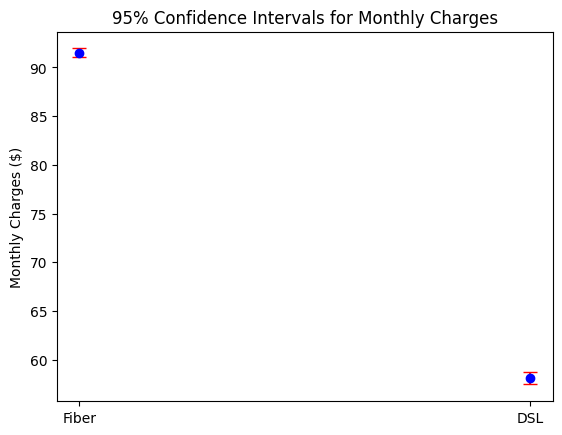

In [4]:
def get_mean_ci(data, confidence=0.95):
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return m, m-h, m+h

fiber_rev = df[df['InternetService']=='Fiber optic']['MonthlyCharges']
dsl_rev = df[df['InternetService']=='DSL']['MonthlyCharges']

m_fiber, low_fiber, high_fiber = get_mean_ci(fiber_rev)
m_dsl, low_dsl, high_dsl = get_mean_ci(dsl_rev)

print(f"Fiber Revenue CI: [${low_fiber:.2f}, ${high_fiber:.2f}]")
print(f"DSL Revenue CI:   [${low_dsl:.2f}, ${high_dsl:.2f}]")

# Visual comparison
import matplotlib.pyplot as plt
plt.errorbar(x=['Fiber', 'DSL'], y=[m_fiber, m_dsl], 
             yerr=[(high_fiber-m_fiber), (high_dsl-m_dsl)], 
             fmt='o', capsize=5, ecolor='red', color='blue')
plt.title('95% Confidence Intervals for Monthly Charges')
plt.ylabel('Monthly Charges ($)')
plt.show()

**Result:** Intervals do not overlap at all. Fiber revenue is distinctly higher.

## 5. Bootstrapping (Non-parametric CI)

For skewed data (like TotalCharges), standard CI formulas might be inaccurate. Let's use Bootstrapping.

Bootstrap 95% CI for Total Charges: [$2228.64, $2331.51]


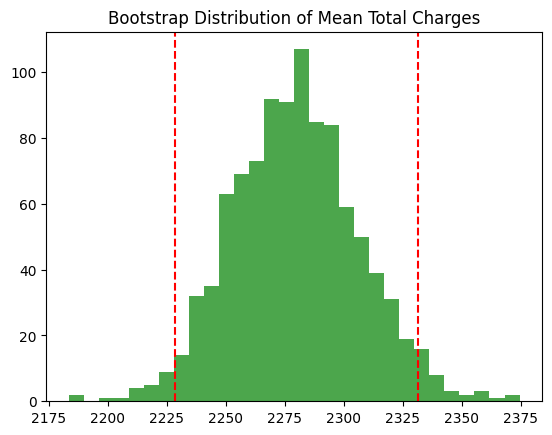

In [5]:
total_charges = df['TotalCharges'].values

# Bootstrap re-sampling (1000 times)
bootstrap_means = []
for _ in range(1000):
    sample = np.random.choice(total_charges, size=len(total_charges), replace=True)
    bootstrap_means.append(np.mean(sample))

# Get percentiles for 95% CI
boot_lower = np.percentile(bootstrap_means, 2.5)
boot_upper = np.percentile(bootstrap_means, 97.5)

print(f"Bootstrap 95% CI for Total Charges: [${boot_lower:.2f}, ${boot_upper:.2f}]")

# Visualize
plt.hist(bootstrap_means, bins=30, alpha=0.7, color='green')
plt.axvline(boot_lower, color='red', linestyle='--')
plt.axvline(boot_upper, color='red', linestyle='--')
plt.title('Bootstrap Distribution of Mean Total Charges')
plt.show()